# Intro to DLC2Action

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a small rat dataset from the SIMBA paper. Run the code below to download the dataset.

In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1zxV5ZFq8cRj7HLGpaTx_bYuAU-2wAOng
!apt-get install unzip
!unzip Rat_RI_homecage_annotations.zip -d rat_simba_data

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14820 sha256=73da5e7a6aeef30fbb03dc4ec545968dfad7d4ce120e5208d3c89386514a84b0
  Stored in directory: /home/liza/.cache/pip/wheels/ed/8a/de/15273923b1f5adacc09306cc48dcedc6b082892569afb2dfc7
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1zxV5ZFq8cRj7HLGpaTx_bYuAU-2wAOng
To: /home/liza/DLC2Action-1/examples/Rat_RI_homecage_annotations.zip
100%|█████████████████████████████████████████| 238M/238M [00:02<00:00, 110MB/s]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Archive:  Rat_RI_homecage_annotations.zip
 

... installation

for now:
```
git clone https://github.com/AlexEMG/DLC2Action
cd DLC2Action
conda create --name DLC2Action python=3.9
conda activate DLC2Action
python -m pip install .
```

In [16]:
from dlc2action.project import Project
import os

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH, "rat_simba_data")
PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"rat_simba"`, with input and annotation data in `"simba"` format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [3]:
# Project.remove_project("rat_simba", projects_path=PROJECTS_PATH)
project = Project(
    "rat_simba",
    data_path=DATA_PATH,
    annotation_path=DATA_PATH,
    projects_path=PROJECTS_PATH,
    data_type="simba",
    annotation_type="simba",
)

Projects have a generalized `help` function.

In [3]:
project.help()

AVAILABLE HELP FUNCTIONS:
- Try running `project.help(keyword)` with the following keywords:
    - model: to get more information on available models,
    - features: to get more information on available feature extraction modes,
    - partition_method: to get more information on available train/test/val partitioning methods,
    - metrics: to see a list of available metric functions.
    - data: to see help for expected data structure
- To start working with this project, first run `project.list_blanks()` to check which parameters need to be filled in.
- After a model and metrics are set, run `project.list_basic_parameters()` to see a list of the most important parameters that you might want to modify
- If you want to dig deeper, get the full dictionary with project._read_parameters() (it is a `ruamel.yaml.comments.CommentedMap` instance).




Let's start by checking if our files are organized correctly.

In [4]:
project.help("data")

DATA:
Video data: simba

   SIMBA paper format data

    Assumes the following file structure

    ```
    data_path
    ├── Video1.csv
    ...
    └── Video9.csv
    ```
    Here `data_suffix` is `.csv`.
    
Annotation data: simba

    SIMBA paper format data

    Assumes the following file structure:
    ```
    annotation_path
    ├── Video1.csv
    ...
    └── Video9.csv
    
Annotation path and data path don't have to be separate, you can keep everything in one folder.




## Setting parameters

After the data structure is sorted out, it's time to configure the parameter settings. 

Every project keeps fixed settings written in configuration files in the project folder. When you want to change something, you have two options: modifying the configuration files so that this new value becomes the default (with `project.set_main_parameters` or `project.update_parameters`) or passing a `parameters_update` argument to your function so that the settings only change for this run.

We will start with setting the defaults.

As we saw in the help message, the first step is checking which essential parameters are missing with `project.list_blanks()`

In [5]:
project.list_blanks()

Before running experiments, please update all the blanks.
To do that, you can run this.
--------------------------------------------------------
project.update_parameters(
    {
        "data": {
            "canvas_shape": ..., # list; [x, y] size of the canvas where the coordinates are defined
            "data_suffix": ..., # str; the data suffix (the data files should be named {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "annotation_suffix": ..., # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        }
        "general": {
            "exclusive": ..., # bool; if true, single-label classification is used; otherwise multi-label
        }
    }
)
--------------------------------------------------------
Replace ... with relevant values.


We can copy this code, fill in the information and run it.

In [6]:
project.update_parameters(
    {
        "data": {
            "canvas_shape": [1290, 730], # list; [x, y] size of the canvas where the coordinates are defined
            "data_suffix": ".csv", # str; the data suffix (the data files should be named {video_id}{data_suffix})
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": False, # bool; if true, single-label classification is used; otherwise multi-label
        }
    }
)

Now we're all set and can start training models. However, we can take an extra step and check out what other parameters are available.

Note that this function is only showing us the parameters for the metric functions and the model that are selected as default at the moment. If you want to see what parameters there are for other models and metrics, try setting them first with `project.set_main_parameters()` or with `project.update_parameters()`.

In [7]:
project.list_basic_parameters()

BASIC PARAMETERS:
Here is a list of current parameters.
You can copy this code, change the parameters you want to set and run it to update the project config.
--------------------------------------------------------
project.update_parameters(
    {
        "general": {
            "model_name": "ms_tcn3", # str; model name (run project.help("model") for more info)
            "metric_functions": {'f1', 'precision', 'recall'}, # set; set of metric names (run project.help("metrics") for more info)
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 128, # int; the length of segments (in frames) to cut the videos into
            "overlap": 0.75, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": ".csv", # str; the data suffi

We can copy this into a code cell to make it easier to read.

In [8]:
project.update_parameters(
    {
        "general": {
            "model_name": "transformer", # str; model name (run project.help("model") for more info)
            "metric_functions": ['f1', 'precision'], 
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 128, # int; the length of segments (in frames) to cut the videos into
            "overlap": 30, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": ".csv", # str; the data suffix (the data files should be named {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "feature_suffix": None, # str; suffix of files with additional features saved as a dictionary (files should be named {video_id}{feature_suffix} and places at data path)
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "canvas_shape": [1290, 730], # list; [x, y] size of the canvas where the coordinates are defined
            "ignored_bodyparts": None, # list; a list of nodypart names to ignore
            "likelihood_threshold": 0, # float; minimum likelihood to load (bodyparts with lower likelihood will be treated as unknown)
            "behaviors": None, # list; the list of behaviors to put in the annotation (if null, if will be inferred from the data; !!PLEASE SET IT MANUALLY if different files can have different behavior sets!!)
            "filter_annotated": False, # bool; if true, the samples that do not have any labels will be filtered
            "filter_background": False, # bool, if true, only the unlabeled frames that are close to annotated frames will be labeled as background
            "visibility_min_score": 0, # float, the minimum visibility score for visibility filtering (from 0 ro 1)
            "visibility_min_frac": 0, # float, the minimum fraction of visible frames for visibility filtering
        },
        "training": {
            "lr": 0.001, # float; learning rate
            "device": "auto", # str; device
            "num_epochs": 10, # int; number of epochs
            "to_ram": False, # bool; transfer the dataset to RAM for training (preferred if the dataset fits in working memory)
            "batch_size": 32, # int; batch size
            "normalize": True, # bool; if true, normalization statistics will be computed on the training set and applied to all data
            "temporal_subsampling_size": 0.85, # float; this fraction of frames in each segment is randomly sampled at training time
            "parallel": False, # bool; if true, the model will be trained on all gpus visible in the system (use os.environ[“CUDA_VISIBLE_DEVICES”] =“{indices}” to exclude gpus in this mode)
            "val_frac": 0.2, # float; fraction of dataset to use as validation
            "test_frac": 0, # float; fraction of dataset to use as test
            "partition_method": "random", # str; the train/test/val partitioning method (for more info run project.help("partition_method"))
        },
        "losses": {
            "ms_tcn": {
                "focal": True, # bool; if True, focal loss will be used
                "gamma": 2, # float; the gamma parameter of focal loss
                "alpha": 0.001, # float; the weight of consistency loss
            },
        },
        "metrics": {
            "f1": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": "None", # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
            "precision": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": "None", # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
        },
        "model": {
            "num_f_maps": 128, # int; number of maps
            "feature_dim": None, # int; if not null, intermediate features are generated with this dimension and then passed to a 2-layer MLP for classification (useful for SSL)
        },
        "features": {
            "keys": None, # set; a list of names of the features to extract (a subset of available keys; run project.help("features") for more info)
            "averaging_window": 1, # int; if >1, features are averaged with a moving window of this size (in frames)
            "distance_pairs": None, # list; a list of bodypart name tuples (e.g. `[("tail", "nose")]`) to compute distances for when `"intra_distance"` is in `keys` (by default all distances are computed)
            "angle_pairs": None, # list; a list of bodypart name tuples (e.g. `[("ear1", "nose", "ear2")]`) for the angle between `"ear1"--"nose"` and `"nose"--"ear2"` lines) to compute angle cosines for when `"angles"` is in `keys` (by default no angles are computed)
            "zone_vertices": None, # dict; a dictionary of bodypart name tuples of any length >= 3 that define zones for `"zone_bools"`and `"zone_distances"` features; keys should be zone names and values should be tuples that define the polygons (e.g. `{"main_area": ("x_min", "x_max", "y_max", "y_min"))}`)
            "zone_bools": None, # list; a list of zone and bodypart name tuples to compute binary identifiers for (1 if an animal is within the polygon or 0 if it's outside) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_bools"` is in `keys`
            "zone_distances": None, # list; a list of zone and bodypart name tuples to compute distances for (distance from the bodypart to the closest of the boundaries) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_distances"` is in `keys`
            "area_vertices": None, # list; a list of bodypart name tuples of any length >= 3 (e.g. `[("ear1", "nose", "ear2", "spine1")]`) that define polygons to compute areas for when `"areas"` is in `keys` (by default no areas are computed)
        },
        "augmentations": {
            "augmentations": {'add_noise', 'mirror'}, # set; a set of augmentations (from 'rotate', 'real_lens', 'add_noise', 'shift', 'zoom', 'mirror', 'switch')
            "rotation_limits": [-1.57, 1.57], # list; list of rotation angle limits in radians ([low, high])
            "mirror_dim": {0}, # set; set of dimensions that can be mirrored (0 for x, 1 for y, 2 for z)
            "noise_std": 0.003, # float; standard deviation of noise
            "zoom_limits": [0.5, 1.5], # list; list of float zoom limits ([low, high])
            "masking_probability": 0.1, # float; the probability of masking a joint
        },
    },
)

Let's see what the options are for metrics and models.

In [9]:
project.help("model")
project.help("metrics")

MODELS:
ms_tcn3:

    A modification of MS-TCN++ model with additional options
    
asformer:

    An implementation of ASFormer
    
mlp:

    A Multi-Layer Perceptron
    
c2f_tcn:

    An implementation of C2F-TCN

    Requires the `"general/len_segment"` parameter to be at least 512
    
edtcn:

    An implementation of EDTCN (Endoder-Decoder TCN)
    
transformer:

    A modification of Transformer-Encoder with additional max-pooling and upsampling
    
    Set `num_pool` to 0 to get a standart transformer-encoder.
    
c2f_transformer:

    A modification of C2F-TCN that replaces some convolutions with attention

    Requires the `"general/len_segment"` parameter to be at least 512
    
actionclip:

    ActionCLIP modification 
    
    Only works with `"clip"` input store and `"clip"` loss.
    


METRICS:
accuracy:

    Accuracy
    
precision:

    Precision
    
f1:

    F1 score
    
recall:

    Recall
    
count:

    Fraction of samples labeled by the model as a class
   

Which models and metrics do you want to try out?

You can choose any metrics but the code will run much faster if you avoid those marked "not advisable for training". We can compute those later with a trained model.

In [10]:
MODEL_NAME1 = "c2f_tcn"
MODEL_NAME2 = "transformer"
METRICS = ["f1", "precision"]

We will configure the metrics in the default parameters, as well as a smaller number of epochs. The model will be updated in each experiment independently, since we want to try out more than one.

In [11]:
project.update_parameters(
    {
        "general": {"metric_functions": METRICS},
        "training": {"num_epochs": 15}
    }
)

All done! Now we're ready to run experiments. 

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

Searches in `DLC2Action` use the `optuna` auto-ML package to sample the hyperpameter space efficiently and save time on trials that go badly from the beginning. 

There are two methods for running a search: `project.run_hyperparameter_search()` and `project.run_default_hyperparameter_search()`. As you might have guessed from the names, the second method will just load the default set of parameters for a given model while the first allows you to optimize whatever you want. For the vast majority of cases `project.run_default_hyperparameter_search()` should be enough, so that is what we will use in thi tutorial.

In [12]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_default_hyperparameter_search(
        f"{model}_search",
        model_name=model,
        metric=METRICS[0],
        num_epochs=10,
        n_trials=5,
        prune=True,
        best_n=3 # we will compare trials based on the average of three best epochs to account for noise
    )


[I 2022-11-01 19:24:27,953] A new study created in memory with name: no-name-5830798f-9519-4d9d-bd90-8abf56e3890c


SEARCH c2f_tcn_search
Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 123/123 [00:00<00:00, 258.95it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.023, 0.009, 0.04, 0.023, 0.013, 5.348, 0.015
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0016, f1 0.139, precision 0.090
validation: loss 0.0021, f1 0.125, precision 0.096
[epoch 2]: loss 0.0015, f1 0.214, precision 0.134
validation: loss 0.0020, f1 0.204, precision 0.279
[epoch 3]: loss 0.0013, f1 0.239, precision 0.148
validation: loss 0.0020, f1 0.283, precision 0.265
[epoch 4]: loss 0.0013, f1 0.252, precision 0.158
validation: loss 0.0019, f1 0.306, precision 0.262
[epoch 5]: loss 0.0012, f1 0.281, precision 0.184
validation: loss 0.0017, f1 0.311, precision 0.255
[epoch 6]: loss 0.0011, f1 0.287, precision 0.189
validation: loss 0.0015, f1 0.305, precision 0.247
[epoch 7]: loss 0.0011, f1 0.312, precision 0.211
validation: loss 0.0014, f1 0.311, precision 0.252
[epoch 8]: loss 0.0011, f1 0.317, precision 0.217
validation: loss 0.0014, f1 0.311, precision 0.255
[epoch 9]: loss 0.0010, f1 0.332, precision 0.230
validation: loss 0.0014, f1 0.306, precision 0.250


[I 2022-11-01 19:25:16,750] Trial 0 finished with value: 0.31443663421286355 and parameters: {'losses/ms_tcn/alpha': 0.0006376715560834498, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9893164630279647, 'model/num_f_maps': 37, 'general/len_segment': 1024}. Best is trial 0 with value: 0.31443663421286355.


[epoch 10]: loss 0.0010, f1 0.338, precision 0.236
validation: loss 0.0013, f1 0.322, precision 0.258
Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.10s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 238/238 [00:00<00:00, 327.32it/s]


Initializing class weights:
     0: 0.002, 0.002, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002 1: 0.025, 0.044, 0.017, 0.077, 0.045, 0.026, 10.348, 0.028
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0008, f1 0.164, precision 0.104
validation: loss 0.0012, f1 0.126, precision 0.231
[epoch 2]: loss 0.0006, f1 0.254, precision 0.163
validation: loss 0.0010, f1 0.301, precision 0.252
[epoch 3]: loss 0.0005, f1 0.284, precision 0.185
validation: loss 0.0006, f1 0.318, precision 0.250
[epoch 4]: loss 0.0005, f1 0.289, precision 0.189
validation: loss 0.0007, f1 0.320, precision 0.250
[epoch 5]: loss 0.0005, f1 0.306, precision 0.202
validation: loss 0.0006, f1 0.360, precision 0.284
[epoch 6]: loss 0.0004, f1 0.332, precision 0.225
validation: loss 0.0008, f1 0.338, precision 0.270
[epoch 7]: loss 0.0004, f1 0.363, precision 0.253
validation: loss 0.0008, f1 0.339, precision 0.273
[epoch 8]: loss 0.0004, f1 0.374, precision 0.266
validation: loss 0.0010, f1 0.336, precision 0.283
[epoch 9]: loss 0.0004, f1 0.379, precision 0.265
validation: loss 0.0009, f1 0.357, precision 0.290


[I 2022-11-01 19:26:09,226] Trial 1 finished with value: 0.36422477204076315 and parameters: {'losses/ms_tcn/alpha': 9.15668175086674e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.8732855232865435, 'model/num_f_maps': 60, 'general/len_segment': 512}. Best is trial 1 with value: 0.36422477204076315.


[epoch 10]: loss 0.0003, f1 0.389, precision 0.279
validation: loss 0.0008, f1 0.376, precision 0.298
Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 123/123 [00:00<00:00, 243.53it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.023, 0.009, 0.04, 0.023, 0.013, 5.348, 0.015
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0004, f1 0.154, precision 0.102
validation: loss 0.0005, f1 0.089, precision 0.282
[epoch 2]: loss 0.0003, f1 0.252, precision 0.165
validation: loss 0.0005, f1 0.264, precision 0.291
[epoch 3]: loss 0.0003, f1 0.292, precision 0.198
validation: loss 0.0005, f1 0.295, precision 0.259
[epoch 4]: loss 0.0003, f1 0.283, precision 0.186
validation: loss 0.0005, f1 0.298, precision 0.254
[epoch 5]: loss 0.0002, f1 0.306, precision 0.208
validation: loss 0.0004, f1 0.309, precision 0.253
[epoch 6]: loss 0.0002, f1 0.334, precision 0.227
validation: loss 0.0004, f1 0.324, precision 0.271
[epoch 7]: loss 0.0002, f1 0.354, precision 0.246
validation: loss 0.0004, f1 0.333, precision 0.278
[epoch 8]: loss 0.0002, f1 0.387, precision 0.274
validation: loss 0.0004, f1 0.365, precision 0.302
[epoch 9]: loss 0.0002, f1 0.421, precision 0.314
validation: loss 0.0004, f1 0.356, precision 0.296


[I 2022-11-01 19:26:32,432] Trial 2 finished with value: 0.3608053636505586 and parameters: {'losses/ms_tcn/alpha': 0.003969267045989505, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9996489034296347, 'model/num_f_maps': 104, 'general/len_segment': 1024}. Best is trial 1 with value: 0.36422477204076315.


[epoch 10]: loss 0.0002, f1 0.443, precision 0.333
validation: loss 0.0004, f1 0.362, precision 0.307
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.023, 0.009, 0.04, 0.023, 0.013, 5.348, 0.015
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0015, f1 0.123, precision 0.074
validation: loss 0.0020, f1 0.179, precision 0.204
[epoch 2]: loss 0.0014, f1 0.181, precision 0.109
validation: loss 0.0020, f1 0.197, precision 0.223


[I 2022-11-01 19:26:36,092] Trial 3 pruned. 


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.023, 0.009, 0.04, 0.023, 0.013, 5.348, 0.015
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0015, f1 0.130, precision 0.074
validation: loss 0.0020, f1 0.232, precision 0.198
[epoch 2]: loss 0.0013, f1 0.214, precision 0.130
validation: loss 0.0019, f1 0.284, precision 0.216
[epoch 3]: loss 0.0012, f1 0.243, precision 0.152
validation: loss 0.0017, f1 0.353, precision 0.315
[epoch 4]: loss 0.0011, f1 0.295, precision 0.195
validation: loss 0.0015, f1 0.355, precision 0.291
[epoch 5]: loss 0.0010, f1 0.322, precision 0.217
validation: loss 0.0013, f1 0.360, precision 0.285
[epoch 6]: loss 0.0010, f1 0.340, precision 0.231
validation: loss 0.0011, f1 0.384, precision 0.295
[epoch 7]: loss 0.0009, f1 0.351, precision 0.240
validation: loss 0.0011, f1 0.351, precision 0.273
[epoch 8]: loss 0.0009, f1 0.352, precision 0.241
validation: loss 0.0011, f1 0.356, precision 0.280
[epoch 9]: loss 0.0008, f1 0.389, precision 0.279
validation: loss 0.0011, f1 0.363, precision 0.287


[I 2022-11-01 19:26:49,137] Trial 4 finished with value: 0.3691070292640792 and parameters: {'losses/ms_tcn/alpha': 3.482154269765296e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.823945353677747, 'model/num_f_maps': 81, 'general/len_segment': 1024}. Best is trial 4 with value: 0.3691070292640792.


[epoch 10]: loss 0.0008, f1 0.405, precision 0.293
validation: loss 0.0013, f1 0.324, precision 0.265
best parameters: {'losses/ms_tcn/alpha': 3.482154269765296e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.823945353677747, 'model/num_f_maps': 81, 'general/len_segment': 1024}


SEARCH transformer_search


[I 2022-11-01 19:26:50,570] A new study created in memory with name: no-name-40573b4e-3060-41c6-8c99-addd46aab377


Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 1869/1869 [00:03<00:00, 498.13it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.342, 0.134, 0.606, 0.357, 0.203, 81.261, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0002, f1 0.283, precision 0.189
validation: loss 0.0002, f1 0.331, precision 0.255
[epoch 2]: loss 0.0001, f1 0.363, precision 0.258
validation: loss 0.0002, f1 0.329, precision 0.254
[epoch 3]: loss 0.0001, f1 0.377, precision 0.269
validation: loss 0.0002, f1 0.330, precision 0.262
[epoch 4]: loss 0.0001, f1 0.383, precision 0.275
validation: loss 0.0002, f1 0.338, precision 0.267
[epoch 5]: loss 0.0001, f1 0.402, precision 0.292
validation: loss 0.0002, f1 0.339, precision 0.275
[epoch 6]: loss 0.0001, f1 0.437, precision 0.323
validation: loss 0.0002, f1 0.381, precision 0.304
[epoch 7]: loss 0.0001, f1 0.448, precision 0.334
validation: loss 0.0002, f1 0.364, precision

[I 2022-11-01 19:28:56,484] Trial 0 finished with value: 0.4043715437501802 and parameters: {'losses/ms_tcn/alpha': 0.0013240942376234932, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.7578769897897474, 'model/N': 10, 'model/heads': 2, 'model/num_pool': 1, 'model/add_batchnorm': False, 'general/len_segment': 64}. Best is trial 0 with value: 0.4043715437501802.


[epoch 10]: loss 0.0001, f1 0.508, precision 0.390
validation: loss 0.0002, f1 0.413, precision 0.335
Computing annotation arrays...


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 1869/1869 [00:03<00:00, 473.04it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.342, 0.134, 0.606, 0.357, 0.203, 81.261, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0006, f1 0.256, precision 0.166
validation: loss 0.0007, f1 0.322, precision 0.251
[epoch 2]: loss 0.0005, f1 0.336, precision 0.236
validation: loss 0.0010, f1 0.338, precision 0.275
[epoch 3]: loss 0.0005, f1 0.347, precision 0.242
validation: loss 0.0008, f1 0.350, precision 0.280
[epoch 4]: loss 0.0006, f1 0.333, precision 0.232
validation: loss 0.0008, f1 0.290, precision 0.224
[epoch 5]: loss 0.0004, f1 0.328, precision 0.227
validation: loss 0.0009, f1 0.305, precision 0.254
[epoch 6]: loss 0.0004, f1 0.364, precision 0.262
validation: loss 0.0008, f1 0.345, precision 0.283
[epoch 7]: loss 0.0003, f1 0.396, precision 0.288
validation: loss 0.0008, f1 0.381, precision

[I 2022-11-01 19:30:36,658] Trial 1 finished with value: 0.3891081994264923 and parameters: {'losses/ms_tcn/alpha': 3.214819808439784e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9823495595936537, 'model/N': 9, 'model/heads': 4, 'model/num_pool': 2, 'model/add_batchnorm': False, 'general/len_segment': 64}. Best is trial 0 with value: 0.4043715437501802.


[epoch 10]: loss 0.0003, f1 0.444, precision 0.334
validation: loss 0.0007, f1 0.401, precision 0.325
Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.342, 0.134, 0.606, 0.357, 0.203, 81.261, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0007, f1 0.213, precision 0.137
validation: loss 0.0006, f1 0.281, precision 0.207
[epoch 2]: loss 0.0006, f1 0.245, precision 0.159
validation: loss 0.0006, f1 0.325, precision 0.268


[I 2022-11-01 19:31:00,059] Trial 2 pruned. 


Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.11s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 937/937 [00:02<00:00, 424.91it/s]


Initializing class weights:
     0: 0.01, 0.008, 0.01, 0.008, 0.008, 0.01, 0.009, 0.01 1: 0.098, 0.172, 0.067, 0.304, 0.179, 0.102, 40.739, 0.111
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0001, f1 0.202, precision 0.120
validation: loss 0.0001, f1 0.302, precision 0.220
[epoch 2]: loss 0.0001, f1 0.250, precision 0.157
validation: loss 0.0001, f1 0.291, precision 0.218


[I 2022-11-01 19:31:50,984] Trial 3 pruned. 


Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Number of samples:
    validation:
      {0: 689, 1: 343, 2: 8551, 3: 308, 4: 912, 5: 3227, 6: 0, 7: 6989}
    training:
      {0: 9581, 1: 5457, 2: 13901, 3: 3084, 4: 5238, 5: 9211, 6: 23, 7: 8427}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 937/937 [00:02<00:00, 380.48it/s]


Initializing class weights:
     0: 0.01, 0.008, 0.01, 0.008, 0.008, 0.01, 0.009, 0.01 1: 0.098, 0.172, 0.067, 0.304, 0.179, 0.102, 40.739, 0.111
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0003, f1 0.259, precision 0.167
validation: loss 0.0004, f1 0.346, precision 0.267
[epoch 2]: loss 0.0003, f1 0.292, precision 0.185
validation: loss 0.0004, f1 0.316, precision 0.231
[epoch 3]: loss 0.0002, f1 0.328, precision 0.221
validation: loss 0.0006, f1 0.330, precision 0.270
[epoch 4]: loss 0.0002, f1 0.366, precision 0.257
validation: loss 0.0005, f1 0.359, precision 0.285
[epoch 5]: loss 0.0002, f1 0.400, precision 0.285
validation: loss 0.0004, f1 0.336, precision 0.264
[epoch 6]: loss 0.0002, f1 0.396, precision 0.283
validation: loss 0.0004, f1 0.392, precision 0.307
[epoch 7]: loss 0.0002, f1 0.455, precision 0.343
validation: loss 0.0004, f1 0.388, precision 0.

[I 2022-11-01 19:32:53,554] Trial 4 finished with value: 0.3926610568269651 and parameters: {'losses/ms_tcn/alpha': 0.0005828345697871582, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.9266959497977901, 'model/N': 12, 'model/heads': 1, 'model/num_pool': 1, 'model/add_batchnorm': False, 'general/len_segment': 128}. Best is trial 0 with value: 0.4043715437501802.


[epoch 10]: loss 0.0001, f1 0.482, precision 0.368
validation: loss 0.0005, f1 0.397, precision 0.320


[W 2022-11-01 19:32:54,063] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,116] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,170] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,215] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,236] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,242] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,249] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,256] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,267] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,272] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11-01 19:32:54,278] Param model/add_batchnorm unique value length is less than 2.
[W 2022-11

best parameters: {'losses/ms_tcn/alpha': 0.0013240942376234932, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.7578769897897474, 'model/N': 10, 'model/heads': 2, 'model/num_pool': 1, 'model/add_batchnorm': False, 'general/len_segment': 64}




Those searches will optimize the hyperparameters to maximize the first metric in our list. Note how some trials stop before reaching 10 epochs. That is happening because we have set `prune=True` to interrupt experiments when they are unlikely to beat the best score.

Generally, it is better to set both the number of trials and the number of epochs much higher (30-50 and around 150, respectively, is usually a good choice). We are setting them low here to save time but keep in mind that it does mean that the parameters those searches find are probably not actually optimal.

The searches have created a bunch of datasets that we are not going to use again so it's a good idea to clean up the memory at this point.

In [13]:
project.remove_datasets()

Removing datasets...


100%|██████████| 4/4 [00:00<00:00, 17.32it/s]

`DLC2Action` needs pre-computed features to run an experiment. It keeps track of features that are stored on your system and does not re-compute them if they have already been created in other experiments with the same data parameters. They can take up a lot of space, however, so it's good practice to remove them sometimes. 

Do not be afraid to run `project.remove_datasets()`, you never lose any information when you do. The features will just be computed again if you need them. In addition, if you are running low on space, it might be more convenient to pass `delete_dataset=True` to project methods to remove the features as soon as they are not needed anymore.

Another function that helps clean up the memory is `project.remove_extra_checkpoints()`. It will remove all model checkpoints except for the last one in each episode.

When the searches are done, we can check out the results.

In [14]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    _ = project.list_best_parameters(f"{model}_search")

SEARCH RESULTS c2f_tcn_search
losses/ms_tcn/alpha: 3.482154269765296e-05
losses/ms_tcn/focal: False
training/temporal_subsampling_size: 0.823945353677747
model/num_f_maps: 81
general/len_segment: 1024


SEARCH RESULTS transformer_search
losses/ms_tcn/alpha: 0.0013240942376234932
losses/ms_tcn/focal: True
training/temporal_subsampling_size: 0.7578769897897474
model/N: 10
model/heads: 2
model/num_pool: 1
model/add_batchnorm: False
general/len_segment: 64




The searches can be used to update the default parameters with `project.update_parameters(load_search=search_name)` but in this case it's more convenient to load them in the relevant episodes.

## Training models

Now we can train models with the best hyperparameters.

In [15]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_episode(
    f"{model}_best",
    load_search=f"{model}_search", # loading the search
    force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
    parameters_update={
        "general": {"model_name": model} # note that you do need to set the model explicitly, it is not loaded with the search
    },
    n_runs=3 # we will repeat the experiment 3 times to get an estimation for how stable our results are
)

TRAINING c2f_tcn_best::0
Computing input features...


100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Number of samples:
    validation:
      {0: 691, 1: 343, 2: 8795, 3: 332, 4: 912, 5: 3227, 6: 0, 7: 7229}
    training:
      {0: 9806, 1: 5642, 2: 14257, 3: 3207, 4: 5328, 5: 9581, 6: 23, 7: 8679}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 123/123 [00:00<00:00, 263.61it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning:

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.

/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 0.0014, f1 0.159, precision 0.100
validation: loss 0.0019, f1 0.260, precision 0.225
[epoch 2]: loss 0.0012, f1 0.237, precision 0.149
validation: loss 0.0018, f1 0.307, precision 0.246
[epoch 3]: loss 0.0011, f1 0.279, precision 0.182
validation: loss 0.0016, f1 0.324, precision 0.259
[epoch 4]: loss 0.0010, f1 0.293, precision 0.192
validation: loss 0.0014, f1 0.338, precision 0.268
[epoch 5]: loss 0.0009, f1 0.332, precision 0.224
validation: loss 0.0012, f1 0.330, precision 0.254
[epoch 6]: loss 0.0009, f1 0.354, precision 0.246
validation: loss 0.0011, f1 0.334, precision 0.264
[epoch 7]: loss 0.0008, f1 0.370, precision 0.262
validation: loss 0.0012, f1 0.294, precision 0.228
[epoch 8]: loss 0.0008, f1 0.379, precision 0.268
validation: loss 0.0013, f1 0.292, precision 0.220
[epoch 9]: loss 0.0007, f1 0.405, precision 0.292
validation: loss 0.0011, f1 0.359, precision 0.278
[epoch 10]: loss 0.0007, f1 0.430, precision 0.314
validation: loss 0.0010, f1 0.339, preci

100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Number of samples:
    validation:
      {0: 691, 1: 343, 2: 8795, 3: 332, 4: 912, 5: 3227, 6: 0, 7: 7229}
    training:
      {0: 9806, 1: 5642, 2: 14257, 3: 3207, 4: 5328, 5: 9581, 6: 23, 7: 8679}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 123/123 [00:00<00:00, 261.22it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning:

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.

/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 0.0014, f1 0.176, precision 0.105
validation: loss 0.0020, f1 0.217, precision 0.241
[epoch 2]: loss 0.0012, f1 0.224, precision 0.136
validation: loss 0.0018, f1 0.309, precision 0.240
[epoch 3]: loss 0.0011, f1 0.260, precision 0.164
validation: loss 0.0014, f1 0.327, precision 0.254
[epoch 4]: loss 0.0011, f1 0.278, precision 0.180
validation: loss 0.0012, f1 0.327, precision 0.254
[epoch 5]: loss 0.0010, f1 0.298, precision 0.195
validation: loss 0.0012, f1 0.318, precision 0.255
[epoch 6]: loss 0.0009, f1 0.325, precision 0.219
validation: loss 0.0013, f1 0.323, precision 0.260
[epoch 7]: loss 0.0009, f1 0.358, precision 0.251
validation: loss 0.0012, f1 0.336, precision 0.264
[epoch 8]: loss 0.0008, f1 0.363, precision 0.252
validation: loss 0.0012, f1 0.334, precision 0.262
[epoch 9]: loss 0.0008, f1 0.383, precision 0.272
validation: loss 0.0012, f1 0.322, precision 0.258
[epoch 10]: loss 0.0007, f1 0.405, precision 0.295
validation: loss 0.0012, f1 0.323, preci

/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning:

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.

/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



[epoch 1]: loss 0.0015, f1 0.161, precision 0.095
validation: loss 0.0019, f1 0.304, precision 0.240
[epoch 2]: loss 0.0013, f1 0.222, precision 0.135
validation: loss 0.0017, f1 0.331, precision 0.252
[epoch 3]: loss 0.0012, f1 0.258, precision 0.163
validation: loss 0.0015, f1 0.337, precision 0.259
[epoch 4]: loss 0.0011, f1 0.276, precision 0.177
validation: loss 0.0013, f1 0.337, precision 0.263
[epoch 5]: loss 0.0010, f1 0.313, precision 0.209
validation: loss 0.0012, f1 0.341, precision 0.269
[epoch 6]: loss 0.0009, f1 0.325, precision 0.217
validation: loss 0.0012, f1 0.330, precision 0.255
[epoch 7]: loss 0.0009, f1 0.346, precision 0.238
validation: loss 0.0011, f1 0.343, precision 0.263
[epoch 8]: loss 0.0008, f1 0.370, precision 0.262
validation: loss 0.0010, f1 0.356, precision 0.272
[epoch 9]: loss 0.0008, f1 0.352, precision 0.242
validation: loss 0.0011, f1 0.348, precision 0.271
[epoch 10]: loss 0.0008, f1 0.395, precision 0.281
validation: loss 0.0011, f1 0.340, preci

100%|██████████| 12/12 [00:25<00:00,  2.16s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Number of samples:
    validation:
      {0: 1290, 1: 644, 2: 16102, 3: 584, 4: 1721, 5: 6056, 6: 0, 7: 13158}
    training:
      {0: 18012, 1: 10244, 2: 26154, 3: 5792, 4: 9857, 5: 17353, 6: 42, 7: 15858}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 3517/3517 [00:06<00:00, 511.06it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.343, 0.134, 0.607, 0.357, 0.203, 83.738, 0.222


/home/liza/DLC2Action-1/dlc2action/project/meta.py:661: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0001, f1 0.325, precision 0.223
validation: loss 0.0003, f1 0.313, precision 0.231
[epoch 2]: loss 0.0002, f1 0.374, precision 0.265
validation: loss 0.0003, f1 0.346, precision 0.272
[epoch 3]: loss 0.0001, f1 0.388, precision 0.276
validation: loss 0.0004, f1 0.374, precision 0.299
[epoch 4]: loss 0.0001, f1 0.408, precision 0.297
validation: loss 0.0005, f1 0.391, precision 0.318
[epoch 5]: loss 0.0001, f1 0.451, precision 0.335
validation: loss 0.0005, f1 0.397, precision 0.313
[epoch 6]: loss 0.0001, f1 0.477, precision 0.359
validation: loss 0.0006, f1 0.412, precision 0.328
[epoch 7]: loss 0.0001, f1 0.510, precision 0.390
validation: loss 0.0006, f1 0.393, precision 0.316
[epoch 8]: loss 0.0001, f1 0.497, precision 0.385
validation: loss 0.0009, f1 0.399, precision 0.327
[epoch 9]: loss 0.0001, f1 0.532, precisi

100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Number of samples:
    validation:
      {0: 1290, 1: 644, 2: 16102, 3: 584, 4: 1721, 5: 6056, 6: 0, 7: 13158}
    training:
      {0: 18012, 1: 10244, 2: 26154, 3: 5792, 4: 9857, 5: 17353, 6: 42, 7: 15858}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 3517/3517 [00:07<00:00, 484.66it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.343, 0.134, 0.607, 0.357, 0.203, 83.738, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0001, f1 0.305, precision 0.204
validation: loss 0.0004, f1 0.353, precision 0.269
[epoch 2]: loss 0.0001, f1 0.404, precision 0.294
validation: loss 0.0006, f1 0.370, precision 0.298
[epoch 3]: loss 0.0001, f1 0.450, precision 0.336
validation: loss 0.0008, f1 0.388, precision 0.310
[epoch 4]: loss 0.0001, f1 0.490, precision 0.377
validation: loss 0.0009, f1 0.388, precision 0.322
[epoch 5]: loss 0.0001, f1 0.510, precision 0.397
validation: loss 0.0010, f1 0.424, precision 0.350
[epoch 6]: loss 0.0000, f1 0.540, precision 0.426
validation: loss 0.0011, f1 0.436, precision 0.364
[epoch 7]: loss 0.0000, f1 0.560, precision 0.444
validation: loss 0.0011, f1 0.422, precision

## Evaluation

Now that we've trained our best models, we can analyze the results. Note that most statistics are aggregated over the 3 experiments we ran automatically. 

In [1]:
best_episodes = [f"{model}_best" for model in [MODEL_NAME1, MODEL_NAME2]]

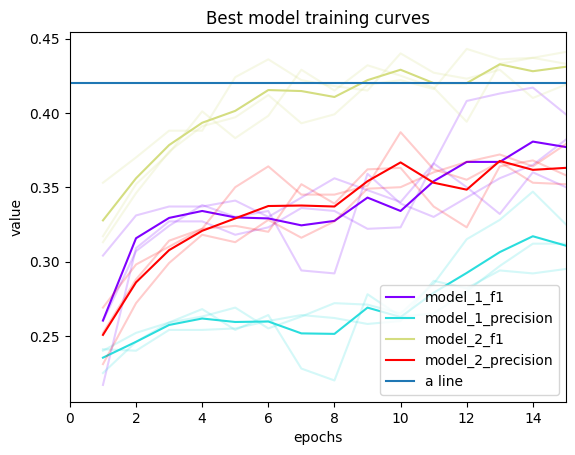

In [2]:
project.plot_episodes(
    best_episodes,
    metrics=METRICS, 
    episode_labels=["model_1", "model_2"], 
    add_hlines=[(0.42, "a line")], # we'll add a random horizontal line here but you can use this parameter to mark important thresholds
    title="Best model training curves"
)

The bold lines here are the means over the three runs of each episode and the transparent lines are the individual runs.

We can also check out more metrics now.

In [3]:
for episode in best_episodes:
    project.evaluate(
        [episode],
        parameters_update={
            "general": {"metric_functions": ["segmental_f1", "mAP", "pr-auc", "f1"]},
            "metrics": {
                "f1": {"average": "none"}
            }
        }
    )

EVALUATION c2f_tcn_best
episode c2f_tcn_best::0
Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Number of samples:
    validation:
      {0: 691, 1: 343, 2: 8795, 3: 332, 4: 912, 5: 3227, 6: 0, 7: 7229}
    training:
      {0: 9806, 1: 5642, 2: 14257, 3: 3207, 4: 5328, 5: 9581, 6: 23, 7: 8679}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/1 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


f1_0 0.093, f1_1 0.065, f1_2 0.875, f1_3 0.316, f1_4 0.234, f1_5 0.607, f1_6 0.000, f1_7 0.864, mAP 0.352, pr-auc 0.208, segmental_f1 0.196


episode c2f_tcn_best::1
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/1 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


f1_0 0.080, f1_1 0.079, f1_2 0.800, f1_3 0.307, f1_4 0.248, f1_5 0.514, f1_6 0.000, f1_7 0.775, mAP 0.287, pr-auc 0.168, segmental_f1 0.186


episode c2f_tcn_best::2
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/1 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


f1_0 0.082, f1_1 0.080, f1_2 0.836, f1_3 0.347, f1_4 0.411, f1_5 0.581, f1_6 0.000, f1_7 0.853, mAP 0.327, pr-auc 0.167, segmental_f1 0.161


AGGREGATED:
f1_0 0.101, f1_1 0.075, f1_2 0.861, f1_3 0.366, f1_4 0.262, f1_5 0.561, f1_6 0.000, f1_7 0.862, mAP 0.330, pr-auc 0.224, segmental_f1 0.202
Inference time: 0:00:00


EVALUATION transformer_best
episode transformer_best::0
Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Number of samples:
    validation:
      {0: 1290, 1: 644, 2: 16102, 3: 584, 4: 1721, 5: 6056, 6: 0, 7: 13158}
    training:
      {0: 18012, 1: 10244, 2: 26154, 3: 5792, 4: 9857, 5: 17353, 6: 42, 7: 15858}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.343, 0.134, 0.607, 0.357, 0.203, 83.738, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 17/17 [00:01<00:00, 12.71it/s]


f1_0 0.062, f1_1 0.107, f1_2 0.793, f1_3 0.381, f1_4 0.638, f1_5 0.694, f1_6 0.000, f1_7 0.854, mAP 0.603, pr-auc 0.371, segmental_f1 0.237


episode transformer_best::1
Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.343, 0.134, 0.607, 0.357, 0.203, 83.738, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 17/17 [00:01<00:00, 11.31it/s]


f1_0 0.071, f1_1 0.134, f1_2 0.816, f1_3 0.224, f1_4 0.566, f1_5 0.702, f1_6 0.000, f1_7 0.835, mAP 0.641, pr-auc 0.279, segmental_f1 0.228


episode transformer_best::2
Initializing class weights:
     0: 0.019, 0.016, 0.02, 0.016, 0.016, 0.019, 0.018, 0.019 1: 0.195, 0.343, 0.134, 0.607, 0.357, 0.203, 83.738, 0.222
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 17/17 [00:01<00:00, 11.97it/s]


f1_0 0.137, f1_1 0.150, f1_2 0.829, f1_3 0.270, f1_4 0.572, f1_5 0.682, f1_6 0.000, f1_7 0.821, mAP 0.621, pr-auc 0.323, segmental_f1 0.241


AGGREGATED:
f1_0 0.109, f1_1 0.160, f1_2 0.824, f1_3 0.322, f1_4 0.630, f1_5 0.709, f1_6 0.000, f1_7 0.839, mAP 0.648, pr-auc 0.354, segmental_f1 0.273
Inference time: 0:00:04




There are several ways to summarize the results.

In [6]:
project.get_results_table(best_episodes)

RESULTS:
               c2f_tcn_best segmental_f1  c2f_tcn_best f1  \
average                         0.181208         0.377000   
anogenital                           NaN         0.084792   
approach                             NaN         0.074922   
attack                               NaN         0.837085   
avoidance                            NaN         0.323580   
boxing                               NaN         0.297621   
lateralthreat                        NaN         0.567237   
pursuit                              NaN         0.000000   
submission                           NaN         0.830766   

               c2f_tcn_best precision  c2f_tcn_best pr-auc  c2f_tcn_best mAP  \
average                      0.310948             0.181033          0.321946   
anogenital                        NaN                  NaN               NaN   
approach                          NaN                  NaN               NaN   
attack                            NaN                  NaN  

,c2f_tcn_best segmental_f1,c2f_tcn_best f1,c2f_tcn_best precision,c2f_tcn_best pr-auc,c2f_tcn_best mAP,transformer_best segmental_f1,transformer_best f1,transformer_best precision,transformer_best pr-auc,transformer_best mAP
average,0.181208,0.377000,0.310948,0.181033,0.321946,0.235341,0.430736,0.362862,0.324709,0.621723
anogenital,NaN,0.084792,NaN,NaN,NaN,NaN,0.089950,NaN,NaN,NaN
approach,NaN,0.074922,NaN,NaN,NaN,NaN,0.130216,NaN,NaN,NaN
attack,NaN,0.837085,NaN,NaN,NaN,NaN,0.812857,NaN,NaN,NaN
avoidance,NaN,0.323580,NaN,NaN,NaN,NaN,0.291537,NaN,NaN,NaN
boxing,NaN,0.297621,NaN,NaN,NaN,NaN,0.591912,NaN,NaN,NaN
lateralthreat,NaN,0.567237,NaN,NaN,NaN,NaN,0.692756,NaN,NaN,NaN
pursuit,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
submission,NaN,0.830766,NaN,NaN,NaN,NaN,0.836658,NaN,NaN,NaN


In [7]:
for episode in best_episodes:
    _ = project.get_summary([episode])

SUMMARY ['c2f_tcn_best']
loss: mean 0.001, std 0.000
f1: mean 0.377, std 0.020
precision: mean 0.311, std 0.012


SUMMARY ['transformer_best']
loss: mean 0.001, std 0.000
f1: mean 0.431, std 0.009
precision: mean 0.363, std 0.012




## Using trained models

After your models are trained, there's a few ways you can use them.

If you're still not very happy with the results, you can train the model for a few more epochs with `project.continue_episode()`.

In [9]:
project.continue_episode(f"{MODEL_NAME1}_best", num_epochs=20, n_runs=3)

TRAINING c2f_tcn_best::0
Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Number of samples:
    validation:
      {0: 691, 1: 343, 2: 8795, 3: 332, 4: 912, 5: 3227, 6: 0, 7: 7229}
    training:
      {0: 9806, 1: 5642, 2: 14257, 3: 3207, 4: 5328, 5: 9581, 6: 23, 7: 8679}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 16]: loss 0.0006, f1 0.471, precision 0.346
validation: loss 0.0012, f1 0.361, precision 0.294
[epoch 17]: loss 0.0005, f1 0.499, precision 0.371
validation: loss 0.0015, f1 0.355, precision 0.314
[epoch 18]: loss 0.0005, f1 0.493, precision 0.377
validation: loss 0.0009, f1 0.405, precision 0.332
[epoch 19]: loss 0.0005, f1 0.505, precision 0.389
validation: loss 0.0009, f1 0.422, precision 0.349
[epoch 20]: loss 0.0005, f1 0.520, precision 0.397
validation: loss 0.0011, f1 0.401, precision 0.343


TRAINING c2f_tcn_best::1
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 16]: loss 0.0006, f1 0.482, precision 0.371
validation: loss 0.0010, f1 0.405, precision 0.330
[epoch 17]: loss 0.0006, f1 0.492, precision 0.380
validation: loss 0.0011, f1 0.377, precision 0.334
[epoch 18]: loss 0.0005, f1 0.489, precision 0.376
validation: loss 0.0011, f1 0.398, precision 0.339
[epoch 19]: loss 0.0005, f1 0.508, precision 0.395
validation: loss 0.0016, f1 0.358, precision 0.322
[epoch 20]: loss 0.0005, f1 0.519, precision 0.403
validation: loss 0.0021, f1 0.326, precision 0.314


TRAINING c2f_tcn_best::2
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 16]: loss 0.0006, f1 0.464, precision 0.340
validation: loss 0.0011, f1 0.395, precision 0.326
[epoch 17]: loss 0.0006, f1 0.498, precision 0.369
validation: loss 0.0010, f1 0.388, precision 0.322
[epoch 18]: loss 0.0005, f1 0.492, precision 0.370
validation: loss 0.0011, f1 0.401, precision 0.336
[epoch 19]: loss 0.0005, f1 0.521, precision 0.398
validation: loss 0.0012, f1 0.412, precision 0.351
[epoch 20]: loss 0.0005, f1 0.531, precision 0.403
validation: loss 0.0014, f1 0.386, precision 0.337




You can also train another episode with different parameters that loads the weights of your model as an initialization. Note that it will use all three runs as starting points for its own three runs.

In [14]:
project.run_episode(
    f"{MODEL_NAME1}_best_lr1e-5",
    load_episode=f"{MODEL_NAME1}_best",
    load_search=f"{MODEL_NAME1}_search",
    parameters_update={
        "general": {"model_name": MODEL_NAME1},
        "training": {"lr": 1e-5, "num_epochs": 5}
    },
    force=True,
)

TRAINING c2f_tcn_best_lr1e-5::0
Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Number of samples:
    validation:
      {0: 691, 1: 343, 2: 8795, 3: 332, 4: 912, 5: 3227, 6: 0, 7: 7229}
    training:
      {0: 9806, 1: 5642, 2: 14257, 3: 3207, 4: 5328, 5: 9581, 6: 23, 7: 8679}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 123/123 [00:00<00:00, 271.31it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0005, f1 0.535, precision 0.417
validation: loss 0.0009, f1 0.419, precision 0.352
[epoch 2]: loss 0.0005, f1 0.528, precision 0.411
validation: loss 0.0009, f1 0.426, precision 0.356
[epoch 3]: loss 0.0005, f1 0.539, precision 0.422
validation: loss 0.0008, f1 0.437, precision 0.363
[epoch 4]: loss 0.0005, f1 0.538, precision 0.419
validation: loss 0.0009, f1 0.440, precision 0.365
[epoch 5]: loss 0.0004, f1 0.541, precision 0.418
validation: loss 0.0008, f1 0.443, precision 0.367


TRAINING c2f_tcn_best_lr1e-5::1
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0005, f1 0.541, precision 0.425
validation: loss 0.0018, f1 0.354, precision 0.329
[epoch 2]: loss 0.0005, f1 0.545, precision 0.428
validation: loss 0.0017, f1 0.372, precision 0.337
[epoch 3]: loss 0.0005, f1 0.537, precision 0.416
validation: loss 0.0016, f1 0.387, precision 0.347
[epoch 4]: loss 0.0004, f1 0.552, precision 0.434
validation: loss 0.0015, f1 0.402, precision 0.353
[epoch 5]: loss 0.0004, f1 0.539, precision 0.419
validation: loss 0.0014, f1 0.416, precision 0.361


TRAINING c2f_tcn_best_lr1e-5::2
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.022, 0.009, 0.038, 0.023, 0.013, 5.348, 0.014
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0005, f1 0.569, precision 0.444
validation: loss 0.0013, f1 0.404, precision 0.349
[epoch 2]: loss 0.0004, f1 0.557, precision 0.431
validation: loss 0.0012, f1 0.414, precision 0.355
[epoch 3]: loss 0.0004, f1 0.565, precision 0.437
validation: loss 0.0012, f1 0.421, precision 0.361
[epoch 4]: loss 0.0004, f1 0.559, precision 0.434
validation: loss 0.0012, f1 0.424, precision 0.362
[epoch 5]: loss 0.0004, f1 0.562, precision 0.436
validation: loss 0.0012, f1 0.427, precision 0.364




You can also plot such episodes together as one line.

/home/liza/DLC2Action-1/dlc2action/project/project.py:2669: UserWarning: Got logs with unequal lengths in parallel runs for combined_model1_f1
  warnings.warn(
/home/liza/DLC2Action-1/dlc2action/project/project.py:2669: UserWarning: Got logs with unequal lengths in parallel runs for combined_model1_precision
  warnings.warn(


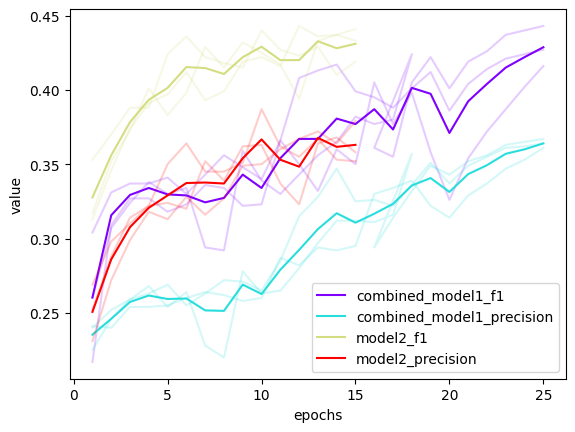

In [17]:
project.plot_episodes(
    [[f"{MODEL_NAME1}_best", f"{MODEL_NAME1}_best_lr1e-5"], f"{MODEL_NAME2}_best"], 
    episode_labels=["combined_model1", "model2"],
    metrics=METRICS
)

All the episodes you have run are stored in the project memory and you can pull up the history with all the parameters.

In [18]:
_ = project.list_episodes(
    display_parameters=["general/model_name", "meta/training_time", "meta/time", f"results/{METRICS[0]}"], # choose the parameters to display
    value_filter="training/lr::>1e-5" # filter the entries by any parameter or result
)

TRAINING EPISODES
                         general          meta                        results
                      model_name training_time                 time        f1
c2f_tcn_best::0          c2f_tcn       0:00:25  2022-11-01 20:59:07  0.401292
c2f_tcn_best::1          c2f_tcn       0:00:24  2022-11-01 20:59:14  0.326330
c2f_tcn_best::2          c2f_tcn       0:00:24  2022-11-01 20:59:21  0.385854
transformer_best::0  transformer       0:03:57  2022-11-01 19:35:23  0.440998
transformer_best::1  transformer       0:03:57  2022-11-01 19:39:44  0.418552
transformer_best::2  transformer       0:03:57  2022-11-01 19:43:43  0.432657




The same goes for hyperparameter searches and predictions. This function also returns a `pandas` table you can process yourself.

In [20]:
searches = project.list_searches(print_results=False)
searches.head()

meta            \
                                   time objective   
c2f_tcn_search      2022-11-01 19:26:50        f1   
transformer_search  2022-11-01 19:32:55        f1   

                                                              results  \
                                                          best_params   
c2f_tcn_search      {'losses/ms_tcn/alpha': 3.482154269765296e-05,...   
transformer_search  {'losses/ms_tcn/alpha': 0.0013240942376234932,...   

                                     data                              \
                   best_value data_prefix feature_suffix canvas_shape   
c2f_tcn_search       0.369107        None           None  [1290, 730]   
transformer_search   0.404372        None           None  [1290, 730]   

                                                                    ...  \
                   ignored_bodyparts likelihood_threshold centered  ...   
c2f_tcn_search                  None                    0    False  ...   
transformer_search              None                    0    False  ...   

                            f1                 precision                  \
                   tag_average threshold_value   average ignored_classes   
c2f_tcn_search           micro             0.5     macro            None   
transformer_search       micro             0.5     macro            None   

                                                           model              \
                   tag_average threshold_value         input_dim     N heads   
c2f_tcn_search           micro             0.5               NaN   NaN   NaN   
transformer_search       micro             0.5  dataset_features  10.0   4.0   

                             
                   num_pool  
c2f_tcn_search          NaN  
transformer_search      3.0  

[2 rows x 110 columns]

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [2]:
project.run_prediction(
    f"{MODEL_NAME1}_best_prediction",
    episode_names=[f"{MODEL_NAME1}_best_lr1e-5"],
    force=True
)

PREDICTION c2f_tcn_best_prediction
episode c2f_tcn_best_lr1e-5::0
Computing input features...


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Number of samples:
    validation:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
    training:
      {0: 10497, 1: 5985, 2: 23052, 3: 3539, 4: 6240, 5: 12808, 6: 23, 7: 15908}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.024, 0.006, 0.04, 0.023, 0.011, 6.13, 0.009
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/5 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 5/5 [00:03<00:00,  1.57it/s]




episode c2f_tcn_best_lr1e-5::1
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.024, 0.006, 0.04, 0.023, 0.011, 6.13, 0.009
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/5 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 5/5 [00:03<00:00,  1.66it/s]




episode c2f_tcn_best_lr1e-5::2
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.013, 0.024, 0.006, 0.04, 0.023, 0.011, 6.13, 0.009
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


  0%|          | 0/5 [00:00<?, ?it/s]/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])
100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

In [8]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path(f"{MODEL_NAME1}_best_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag"]:
        print(f'{key}: {value.shape}')

start = 50
end = 70
action = "attack"

behavior_dictionary = project.get_behavior_dictionary(f"{MODEL_NAME1}_best_lr1e-5::0")
for index, behavior in behavior_dictionary.items():
    if behavior == action:
        break

print(f'The mean probability of {action} between frames {start} and {end} is {prediction["1+2"][index, start: end].mean()}')

1+2: torch.Size([8, 11392])
The mean probability of attack between frames 50 and 70 is 0.13511013984680176


In [ ]:
project.remove_datasets()
project.remove_extra_checkpoints()

Removing datasets...




## Working with custom data

If you want to work with your own data, first check `Project.print_data_types()` and `Project.print_annotation_types()` to check if we already have the format that you need.

If we don't, you can choose either of them to transform your data to but the easiest is probably `DeepLabCut` track or tracklet for the pose estimation data and our custom `"dlc"` format for annotation.

Let's talk about the latter in more detail.

It assumes every annotation file to be a pickled nested dictionary where first-level keys are individual names, second-level keys are behavior names and values are lists of intervals. Here is an example.
```
{
    "ind0": {
        "running": [[20, 30], [40, 50]]
    },
    "ind1": {
        "eating": [[10, 56]]
    }
}
```

Here `"ind0"` is running in frames 20 to 30 and 40 to 50 while `"ind1"` is eating in frames 10 to 56.

In case your dataset contains interactive actions, connect the individual names with a plus (e.g. `"ind0+ind1"`). At the moment, we can only support two scenarios: either all actions are interactive or all are individual. In case they are interactive, update the parameters with `project.update_parameters({"general": {"interactive": True}})` before running experiments.

As an exercise, let's generate a file in this format from one of the CSV files we've been working with.

In [2]:
import os
import pandas as pd
import numpy as np
import pickle

filename = [x for x in os.listdir(DATA_PATH) if x.endswith(".csv")][0] # load a random .csv file
filepath = os.path.join(DATA_PATH, filename)

data = pd.read_csv(filepath)

In [18]:
data.head()

,scorer,Ear_left_1_x,Ear_left_1_y,Ear_left_1_p,Ear_right_1_x,Ear_right_1_y,Ear_right_1_p,Nose_1_x,Nose_1_y,Nose_1_p,...,lateralthreat_prediction,pursuit_prediction,anogenital_prediction,submission_prediction,boxing_prediction,approach_prediction,avoidance_prediction,boxing_prediction.1,approach_prediction.1,avoidance_prediction.1
0,0,247,405,0.999989,305,376,0.999968,233,309,0.999979,...,0,0,0,0,0,0,0,0,0,0
1,1,246,404,0.999996,305,376,0.999980,237,308,0.999884,...,0,0,0,0,0,0,0,0,0,0
2,2,246,406,0.999984,307,376,0.999988,226,309,0.999948,...,0,0,0,0,0,0,0,0,0,0
3,3,249,408,0.999971,304,374,0.999984,224,311,0.999900,...,0,0,0,0,0,0,0,0,0,0
4,4,248,414,0.999963,303,373,0.999975,214,320,0.999693,...,0,0,0,0,0,0,0,0,0,0


Behaviors here are interactive, the animal names are `"1"` and `"2"` and the annotations are encoded as binary arrays in the last columns. Let's use this to generate our dictionary.

In [3]:
for filename in [x for x in os.listdir(DATA_PATH) if x.endswith(".csv")]:
    filepath = os.path.join(DATA_PATH, filename)
    data = pd.read_csv(filepath)
    dlc_dict = {"1+2": {}}
    behavior_columns = [column for column in data.columns if column.endswith("prediction")] # get relevant columns
    for column in behavior_columns:
        behavior = column.split("_")[0] # get the name of the behavior
        diff = np.diff(np.pad(data[column].values, (1, 1))) # find the starts and ends of positive intervals
        start_indices = np.where(diff == 1)[0]
        end_indices = np.where(diff == -1)[0]
        dlc_dict["1+2"][behavior] = []
        for start, end in zip(start_indices, end_indices):
            dlc_dict["1+2"][behavior].append([start, end]) # add intervals to the dictionary
    new_name = filepath.split(".")[0] + "_dlc.pickle" # the filenames need to start with the video name
    with open(new_name, "wb") as f: # save the annotation file
        pickle.dump(dlc_dict, f)

Let's check that we did everything right. We will create a new project with the new data type and run a small experiment.

In [4]:
project = Project(
    "rat_simba_dlc",
    data_path=DATA_PATH,
    annotation_path=DATA_PATH,
    data_type="simba",
    annotation_type="dlc",
    projects_path=PROJECTS_PATH
)

In [5]:
project.update_parameters(
    {
        "data": {
            "canvas_shape": [1290, 730], # list; [x, y] size of the canvas where the coordinates are defined
            "data_suffix": ".csv", # str; the data suffix (the data files should be named {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "annotation_suffix": "_dlc.pickle", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": False, # bool; if true, single-label classification is used; otherwise multi-label
            "interactive": True,
            "model_name": "c2f_tcn",
            "len_segment": 512
        },
        "augmentations": {
            "augmentations": {"add_noise", "mirror", "rotate"}, # set; a set of augmentations that can be applied to your data without losing information (choose any number from 'rotate', 'real_lens', 'add_noise', 'shift', 'zoom', 'mirror', 'switch', e.g. {'add_noise'. 'mirror'})
        },
        "training": {"num_epochs": 5},
    }
)

In [6]:
project.remove_datasets()
project.run_episode("test", force=True)

Removing datasets...


TRAINING test
Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.15s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:00<00:00, 3028.01it/s]


Number of samples:
    validation:
      {0: 2672, 1: 1292, 2: 34204, 3: 1232, 4: 3648, 5: 12609, 6: 0, 7: 27956}
    training:
      {0: 37224, 1: 21212, 2: 55418, 3: 11922, 4: 20826, 5: 36280, 6: 92, 7: 33623}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 937/937 [00:02<00:00, 347.67it/s]


Initializing class weights:
     0: 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002 1: 0.025, 0.044, 0.017, 0.079, 0.045, 0.026, 10.185, 0.028
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action-1/dlc2action/model/c2f_tcn.py:78: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diff // 2, diff - diff // 2])


[epoch 1]: loss 0.0006, f1 0.219, precision 0.132, recall 0.879
validation: loss 0.0017, f1 0.260, precision 0.266, recall 0.337
[epoch 2]: loss 0.0004, f1 0.323, precision 0.218, recall 0.908
validation: loss 0.0007, f1 0.361, precision 0.288, recall 0.669
[epoch 3]: loss 0.0003, f1 0.368, precision 0.256, recall 0.918
validation: loss 0.0005, f1 0.404, precision 0.319, recall 0.727
[epoch 4]: loss 0.0003, f1 0.411, precision 0.300, recall 0.928
validation: loss 0.0009, f1 0.339, precision 0.263, recall 0.720
[epoch 5]: loss 0.0003, f1 0.414, precision 0.296, recall 0.933
validation: loss 0.0014, f1 0.319, precision 0.290, recall 0.636




## Annotation

You can also use `DLC2Action` to generate new annotation files. Install our interface following those instructions and try running it with any video you like.

... Installation

for now:
```
git clone https://github.com/amathislab/dlc2action_annotation
cd dlc2action_annotation
conda env create -f AnnotationGUI.yaml
```

To start, go to the `dlc2action_annotation` folder and run `python annotator.py`.